# Working with FITS Images from the FLI Proline CCD

A Notebook showing some python image analysis of CCD data. Copy this notebook and run all the cells yourself. 

To get your data into your Jupyter Server, from a command line on your computer try to do:

`scp -r DIRECTORY yourname@notebook.kinsc.haverford.edu:/homes/yourname/DESTINATION/.`

Or you can: 
* Download the data from Google drive
* Unzip it to check it's all there
* Upload the zip file using the Jupyter "Upload" button
* Unzip it on the Jupyter hub using "unzip FILE.zip" in a terminal window
* Google this process if you need help. 

To unzip in a Notebook you can use this code (from Roma Hdlaky): 

```import zipfile
with zipfile.ZipFile("CCD data 10.5.zip", "r") as zip_ref1:
    zip_ref1.extractall()```

If you want to use my backup data you can find it here: 

`/homes/astro341/CCD_Data/`

If running this at Haverford, make sure to use the `python3.10.10` kernel. 

In [7]:
#import statements may not all be needed
from astropy.io import fits
from matplotlib import pyplot as plt
import numpy as np
import os as os
from astropy import units as u

#Modules for CCD processing
import ccdproc as ccdp
from astropy.nddata import CCDData

#for 3 colour images
from astropy.visualization import make_lupton_rgb

#Aliging images
#from astropy.wcs import WCS

#Nicer plot styles
from astropy.visualization import astropy_mpl_style, stretch, interval, mpl_normalize
plt.style.use(astropy_mpl_style)

#Aperture photometry 
import photutils.aperture
from photutils import CircularAperture
from photutils import aperture_photometry

#Plot inline
%matplotlib inline

# Location of data (change this to where your data are)
file_root = "/homes/astr341/CCD_Data/"

# Reading in FITS images and Bias Frames

In [5]:
#Import a small number of files

#Import using fit.open
bias0 = fits.open(file_root+"Bias/biasS0.FIT")
bias1 = fits.open(file_root+"Bias/biasS1.FIT")

In [8]:
#Opening as a CCD object in ccdproc also works, and 
# means you can make use of some pre-written functions. 
bias2 = CCDData.read(file_root+"Bias/biasS2.FIT", unit="adu")  

head2=bias2[0].header
head2

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                 4096 / length of data axis 1                          
NAXIS2  =                 4096 / length of data axis 2                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
BZERO   =               32768. / DATA ZERO                                      
BSCALE  =                   1. / DATA SCALE                                     
EXPTIME =                   0. / duration of exposure in seconds                
XBINNING=                    1 / binning factor used on X axis                  
YBINNING=                   

In [9]:
#Extract the image data (usually in extension 0). 
#Astype(float) converts the numbers from unsigned integers to floats, which will prevent problems
#if you try to do operations which would result in negative numbers. 
biasimg0=bias0[0].data.astype(float)
biasimg1=bias1[0].data.astype(float)
biasimg2=bias2[0].data.astype(float)

print, 'Image sizes: ', biasimg0.shape,biasimg1.shape,biasimg1.shape

(<function print>, 'Image sizes: ', (4096, 4096), (4096, 4096), (4096, 4096))

In [10]:
#You can now do normal math with these arrays. E.g. Stats of the numbers in the array. 
#The difference or sum of multiple arrays. 

print('Median pixel value of a bias frame: ', np.median(biasimg0),np.median(biasimg1),np.median(biasimg2))
print('Standard deviation of pixel values in a bias frame: ', np.std(biasimg0),np.std(biasimg1),np.std(biasimg2))

average=(biasimg0+biasimg1)/2.0
#Recall this is still 4096x4096 numbers, so:
print('Median pixel value of average frame: ', np.median(average))

diff=1.0000*biasimg0-1.0000*biasimg1
diff2=1.0000*biasimg2-1.0000*biasimg1
#Recall this is still 4096x4096 numbers, so:
print('Median pixel value of difference frame (what should this be?): ', np.median(diff), np.median(diff2))
print('Standard deviation of pixel values in a difference frame: ', np.std(diff),np.std(diff2))

print('Sizes: ', diff.shape,average.shape)

print('Square of the ratio of SD of difference and single frame (what should this be?): ', (np.std(diff)/np.std(biasimg0))**2)

Median pixel value of a bias frame:  1042.0 1042.0 1042.0
Standard deviation of pixel values in a bias frame:  11.925917804841124 11.928986065109319 11.927539821978847
Median pixel value of average frame:  1042.5
Median pixel value of difference frame (what should this be?):  0.0 0.0
Standard deviation of pixel values in a difference frame:  16.385611728317766 16.55783341763992
Sizes:  (4096, 4096) (4096, 4096)
Square of the ratio of SD of difference and single frame (what should this be?):  1.887737902123201


In [11]:
#You can import a bunch of files from a list: 

#Create the list of input files
indir=file_root+'Bias/'  #Replace!
filelist=[]
for file in os.listdir(indir):
    if (file.endswith(".FIT")): 
        filelist.append(os.path.join(indir, file))

#Define the output directory (directory/folder must exist already and be in your space)
outdir='Reduced/'
print(filelist)  #Run this command to check your list of files makes sense



['/homes/astr341/CCD_Data/Bias/biasS0.FIT', '/homes/astr341/CCD_Data/Bias/biasS1.FIT', '/homes/astr341/CCD_Data/Bias/biasS2.FIT', '/homes/astr341/CCD_Data/Bias/biasS3.FIT', '/homes/astr341/CCD_Data/Bias/biasS4.FIT', '/homes/astr341/CCD_Data/Bias/biasS5.FIT', '/homes/astr341/CCD_Data/Bias/biasS6.FIT', '/homes/astr341/CCD_Data/Bias/biasS7.FIT', '/homes/astr341/CCD_Data/Bias/biasS8.FIT', '/homes/astr341/CCD_Data/Bias/biasS9.FIT']


## Make Combined Bias in Python

In [14]:
#This command from CCDProc can do all sorts of versions of averaging. 
#This is a good way to make final best average arrays. 
#This will not overwrite a file - so you will have to change the output_file name or 
#delete the previous version to run more than once

combined_bias = ccdp.combine(filelist, unit='adu',
                             output_file=outdir+'averaged_bias.fit',overwrite=True)

print(combined_bias.shape)

(4096, 4096)


In [9]:
#CCDProc also has routines to search for images with given strings in the name. 
#I didn't get this to work yet. I'm not sure why. Keeping here as a comment. 
#Don't run this cell unles you want to figure out what it's not working. 

#Define the list of bias images
biases = ccdp.ImageFileCollection(indir,glob_include='*.FIT') 
#Print out basic info about images to make sure you got the right ones
biases.summary['file', 'imagetyp', 'exptime', 'naxis1', 'naxis2']
bias_files = overscan_biases.files_filtered(include_path=True)


TypeError: 'NoneType' object is not subscriptable

# Plotting Images

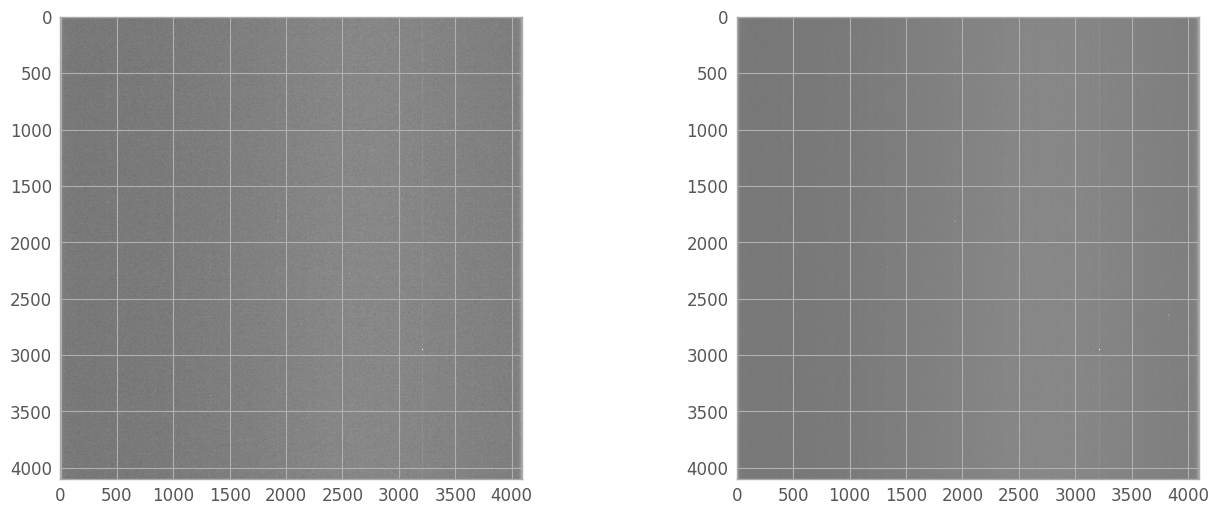

In [15]:
#You might like to reload and make a plot of the bias images. 
#Think about why the average and single frame differ. 

avbias_file=outdir+'averaged_bias.fit' 
avbias_hdul = fits.open(avbias_file)   #Read in bias image
avbias_img = avbias_hdul[0].data

bias_hdul = fits.open(filelist[0])
bias_img = bias_hdul[0].data

fig=plt.figure(figsize=(16,6))
#Plot bias image
ax1=fig.add_subplot(121)
ax1.imshow(bias_img, cmap='gray',vmin=np.median(bias_img)*0.95, vmax=np.median(bias_img)*1.05)
ax2=fig.add_subplot(122)
ax2.imshow(avbias_img, cmap='gray',vmin=np.median(bias_img)*0.95, vmax=np.median(bias_img)*1.05)

# Dark Frames and Dark Current

In [16]:
#Import Darks
#Create the list of input files
indir=file_root+'Darks/'  #Replace!
filelist=[]
for file in os.listdir(indir):
    if (file.endswith(".fit")): 
        filelist.append(os.path.join(indir, file))
#Run this command to check your list of files makes sense
for x in filelist:
    print(x)  

/homes/astr341/CCD_Data/Darks/dark10min_13C.fit
/homes/astr341/CCD_Data/Darks/dark10min_18C.fit
/homes/astr341/CCD_Data/Darks/dark10min_23C.fit
/homes/astr341/CCD_Data/Darks/dark2min_13C.fit
/homes/astr341/CCD_Data/Darks/dark30min_13C.fit
/homes/astr341/CCD_Data/Darks/dark5min_13C.fit


In [17]:
#Dark current as a function of temp (index numbers are hard coded and based on filelist above)

avbias_file=outdir+'averaged_bias.fit' 
avbias_hdul = fits.open(avbias_file)   #Read in bias image
avbias_img = avbias_hdul[0].data.astype(float)

Temp = [13.0,18.0,23.0]
darkcurrent=[0.0,0.0,0.0]
for i in range(3):
    print(filelist[i])
    darkfile = fits.open(filelist[i])
    dark_img = darkfile[0].data.astype(float)-avbias_img
    darkcurrent[i]=np.median(dark_img)
 
#Debugging line
print(Temp,darkcurrent)

/homes/astr341/CCD_Data/Darks/dark10min_13C.fit
/homes/astr341/CCD_Data/Darks/dark10min_18C.fit
/homes/astr341/CCD_Data/Darks/dark10min_23C.fit
[13.0, 18.0, 23.0] [167.4000000000001, 361.9000000000001, 674.4000000000001]


Fitted line y=ax+b:  [  50.7        -511.36666667]


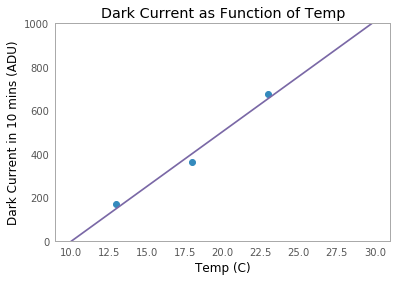

In [13]:
#Fit a line (1st order polynomial)
fit = np.polyfit(Temp, darkcurrent, 1)
print("Fitted line y=ax+b: ", fit)
a=fit[0]
b=fit[1]
x=np.linspace(10,30,30)
y = a*x+b

#Make a plot showing data and fit
plt.plot(Temp,darkcurrent,'o')
plt.plot(x,y)
plt.ylim(0,1000)

#Title
plt.title('Dark Current as Function of Temp')

#Axis labels
plt.xlabel("Temp (C)")
plt.ylabel("Dark Current in 10 mins (ADU)")

#Add a grid
plt.grid()

#Add a legend box
#plt.legend()

#Actually show the plot
plt.show()

In [25]:
#Import Darks
#Create the list of input files
indir=file_root+'Darks/'  #Replace!
filelist=[]
for file in os.listdir(indir):
    if (file.endswith("13C.fit")): 
        filelist.append(os.path.join(indir, file))
#Run this command to check your list of files makes sense
for x in filelist:
    print(x)  

/homes/astr341/CCD_Data/Darks/dark10min_13C.fit
/homes/astr341/CCD_Data/Darks/dark2min_13C.fit
/homes/astr341/CCD_Data/Darks/dark30min_13C.fit
/homes/astr341/CCD_Data/Darks/dark5min_13C.fit


[10.0, 2.0, 30.0, 5.0] [167.4000000000001, 36.40000000000009, 508.79999999999995, 83.0]
Fitted line y=ax+b:  [16.94284216 -0.17839539]


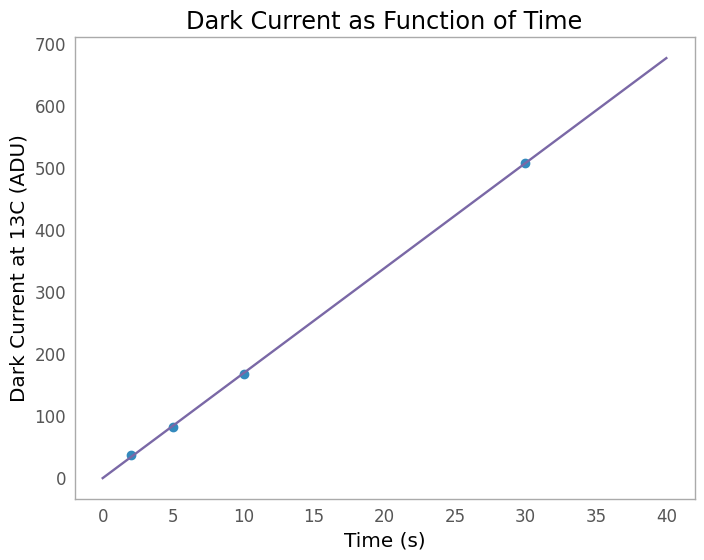

In [20]:
#Dark current as a function of time (index numbers are hard coded and based on filelist above)

Time = [10.0,2.0,30.0,5.0]
darkcurrent=[0.0,0.0,0.0,0.0]
for i in range(4):
    darkfile = fits.open(filelist[i])
    dark_img = darkfile[0].data.astype(float)-avbias_img
    darkcurrent[i]=np.median(dark_img)
 
#Debugging line
print(Time,darkcurrent)
#Time=Time*60.0

fit = np.polyfit(Time, darkcurrent, 1)
print("Fitted line y=ax+b: ", fit)
a=fit[0]
b=fit[1]
x=np.linspace(0,40,30)
y = a*x+b

#Make a plot
plt.plot(Time,darkcurrent,'o')
plt.plot(x,y)

#Title
plt.title('Dark Current as Function of Time')

#Axis labels
plt.xlabel("Time (s)")
plt.ylabel("Dark Current at 13C (ADU)")

#Add a grid
plt.grid()

#Add a legend box
#plt.legend()

#Actually show the plot
plt.show()

In [26]:
#30 Min Dark current calibrated to 1s. 30min=1800s: 
print(filelist[2])
darkfile = darkfile = fits.open(filelist[2])
#Subtract bias
dark_img = darkfile[0].data.astype(float)-avbias_img
print('Median dark current in 30min: ',np.median(dark_img))
#Divide by 1800
dark_img = dark_img/1800
print('Median dark current in 1s: ',np.median(dark_img))

/homes/astr341/CCD_Data/Darks/dark30min_13C.fit
Median dark current in 30min:  508.79999999999995
Median dark current in 1s:  0.2826666666666666


In [27]:
#This is all fine, but there is a way to do it which helps keep headers straight in CCDproc. 

#Use CCDdata to open files. 
avbias=CCDData.read(outdir+'averaged_bias.fit', unit="adu")
dark = CCDData.read(filelist[2], unit="adu")

#Subtract bias
darkreduced = ccdp.subtract_bias(dark, avbias)
print('Median dark current in 30min: ',np.median(darkreduced))

#Divide by 1800
time = 1800.0
dark1s = darkreduced.divide(time)
print('Median dark current in 1s: ',np.median(dark1s))

#Then outputting as a FITS with an appropriate header will work. 

#This should change the EXPTIME in the header. 
dark1s.header['EXPTIME'] = 1.0

dark1s.write(outdir+'dark1s.fits')

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/packages/python3.10.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Median dark current in 30min:  508.79999999999995
Median dark current in 1s:  0.2826666666666666


# Flat Field Images

In [28]:
#Now let's look at a flat field. Recall this is an image with uniform illimination - all pixels should have 
#had the same photon flux land on them, so any deviations are from sensitivity variations. 
#There is a wide variety of exposure times of g r and i-band flats in the test data. 

#Import Flat fields
#Create the list of input files
indir=file_root+'/DomeFlatfields/'  #Replace with path to your files!
filelist=[]
for file in os.listdir(indir):
    if (file.endswith(".FIT")): 
        filelist.append(os.path.join(indir, file))
#Run this command to check your list of files makes sense
for x in filelist:
    print(x)  

/homes/astr341/CCD_Data//DomeFlatfields/flat_g_0.3S1.FIT
/homes/astr341/CCD_Data//DomeFlatfields/flat_g_0.3S2.FIT
/homes/astr341/CCD_Data//DomeFlatfields/flat_g_0.5S1.FIT
/homes/astr341/CCD_Data//DomeFlatfields/flat_g_0.5S2.FIT
/homes/astr341/CCD_Data//DomeFlatfields/flat_g_1.5S1.FIT
/homes/astr341/CCD_Data//DomeFlatfields/flat_g_1.5S2.FIT
/homes/astr341/CCD_Data//DomeFlatfields/flat_g_1S3.FIT
/homes/astr341/CCD_Data//DomeFlatfields/flat_g_1S4.FIT
/homes/astr341/CCD_Data//DomeFlatfields/flat_g_2.5S1.FIT
/homes/astr341/CCD_Data//DomeFlatfields/flat_g_2.5S2.FIT
/homes/astr341/CCD_Data//DomeFlatfields/flat_g_2S1.FIT
/homes/astr341/CCD_Data//DomeFlatfields/flat_g_2S2.FIT
/homes/astr341/CCD_Data//DomeFlatfields/flat_g_3S1.FIT
/homes/astr341/CCD_Data//DomeFlatfields/flat_g_3S2.FIT
/homes/astr341/CCD_Data//DomeFlatfields/flat_g_4S1.FIT
/homes/astr341/CCD_Data//DomeFlatfields/flat_g_4S2.FIT
/homes/astr341/CCD_Data//DomeFlatfields/flat_g_5S1.FIT
/homes/astr341/CCD_Data//DomeFlatfields/flat_g_5S

File to open:  /homes/astr341/CCD_Data//DomeFlatfields/flat_g_4S1.FIT
(4096, 4096)
CCD Temp: 13.0


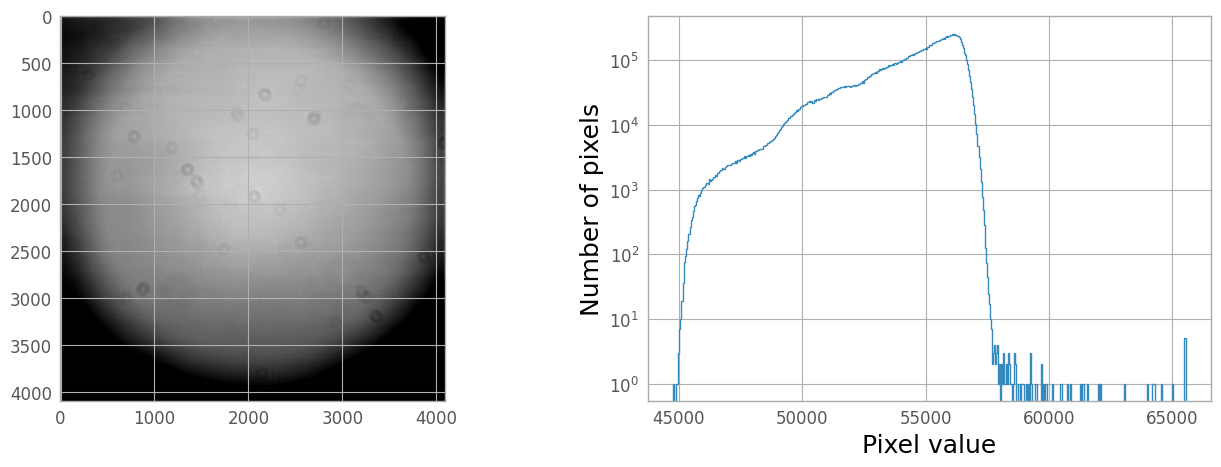

In [29]:
#Look at a single flat. You can use the backup data to find a saturated flat. 
file=filelist[14]
print('File to open: ',file)
flat_hdul = fits.open(file)   #Read in pre-subtraction image
flat_img = flat_hdul[0].data.astype(float)

fig=plt.figure(figsize=(16,5))
#Plot image
ax1=fig.add_subplot(121)
ax1.imshow(flat_img, cmap='gray',vmin=np.median(flat_img)*0.95, vmax=np.median(flat_img)*1.05)

ax2=fig.add_subplot(122)
ax2.hist(flat_img.flatten(),histtype='step',bins=500)
ax2.set_yscale('log')
ax2.set_xlabel('Pixel value',fontsize=18)
ax2.set_ylabel('Number of pixels',fontsize=18)

#Print out shape of image to make sure it's been overscan-subtracted
print(np.shape(flat_img))
print("CCD Temp:",flat_hdul[0].header["CCD-TEMP"])


In [31]:
#Import Flat fields in g-band with 4s exposure. 
#Create the list of input files
indir=file_root+'DomeFlatfields/'  #Replace with the path to your files!
filelist=[]
for file in os.listdir(indir):
    if (file.endswith(".FIT") and file.startswith("flat_g_4S") ): 
        filelist.append(os.path.join(indir, file))
#Run this command to check your list of files makes sense
for x in filelist:
    print(x)  

/homes/astr341/CCD_Data/DomeFlatfields/flat_g_4S1.FIT
/homes/astr341/CCD_Data/DomeFlatfields/flat_g_4S2.FIT


In [32]:
#First we remove the bias and dark current
avbias=CCDData.read(outdir+'averaged_bias.fit', unit="adu")
dark1800=CCDData.read(file_root+'Darks/dark30min_13C.fit', unit="adu")

flat0 = CCDData.read(filelist[0], unit="adu")  #Read in pre-subtraction image
flat1 = CCDData.read(filelist[1], unit="adu")  #Read in pre-subtraction image

#Subtract the bias
reduced_flat0 = ccdp.subtract_bias(flat0, avbias)
reduced_flat1 = ccdp.subtract_bias(flat1, avbias)

#Subtract the dark from the flat field images
reduced_flat0 = ccdp.subtract_dark(reduced_flat0, dark1800,
                              exposure_time='EXPTIME', #Name of exposure time in header
                              exposure_unit=u.second)

reduced_flat1 = ccdp.subtract_dark(reduced_flat1, dark1800,
                              exposure_time='EXPTIME', #Name of exposure time in header
                              exposure_unit=u.second)

reducedlist=[reduced_flat0,reduced_flat1]

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


In [33]:
#This command from CCDProc can do all sorts of versions of averaging. 
#This is a good way to make final best average arrays. 
#Ideally you have more than two flats to combine

print(outdir)
gflat = ccdp.combine(reducedlist, unit='adu', sigma_clip=True,
                             output_file=outdir+'averaged_gflat4.fit')

Reduced/


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
Median pixel value of the g-band flat:  52319.2
Median pixel value of the normalized g-band flat:  1.0


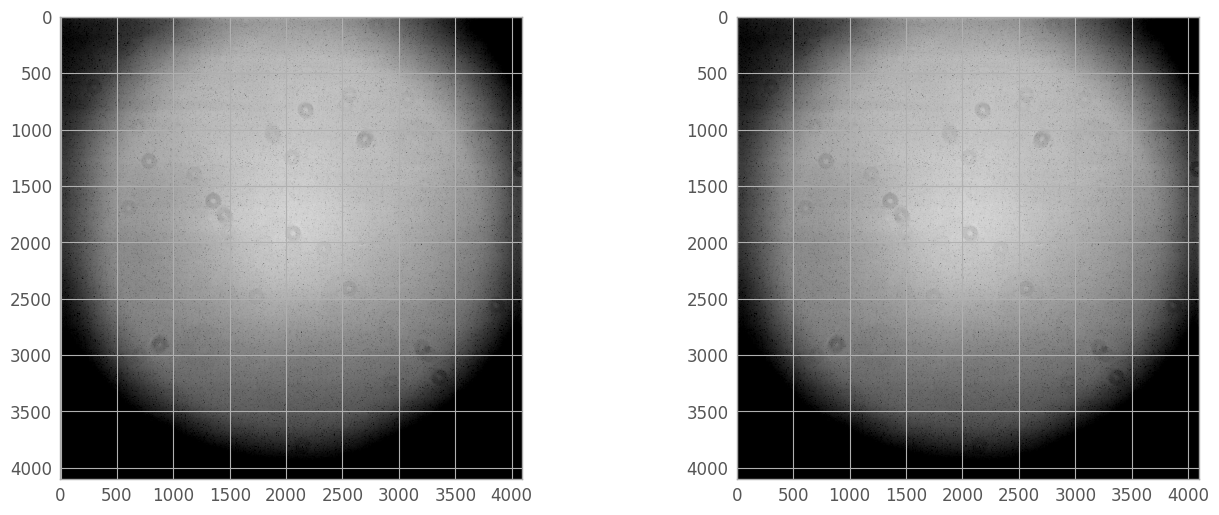

In [34]:
#Flat field normalization
avgflat=CCDData.read(outdir+'averaged_gflat4.fit', unit="adu")
print('Median pixel value of the g-band flat: ', np.median(avgflat))

normgflat=avgflat.divide(np.median(avgflat))
print('Median pixel value of the normalized g-band flat: ', np.median(normgflat))

fig=plt.figure(figsize=(16,6))
#Plot bias image
ax1=fig.add_subplot(121)
ax1.imshow(avgflat, cmap='gray',vmin=np.median(avgflat)*0.95, vmax=np.median(avgflat)*1.05)

ax2=fig.add_subplot(122)
ax2.imshow(normgflat, cmap='gray',vmin=np.median(normgflat)*0.95, vmax=np.median(normgflat)*1.05)

#However, the below CCDPROC procedure divides the flat by the median 
#before doing the correction, so we don't need to save the normalized one. 
#flatcorrected = ccdproc.flat_correct(avgflat, normgflat)
#This comment just provided for information. You don't need to do anything with it here. 


Text(0, 0.5, 'Number of pixels')

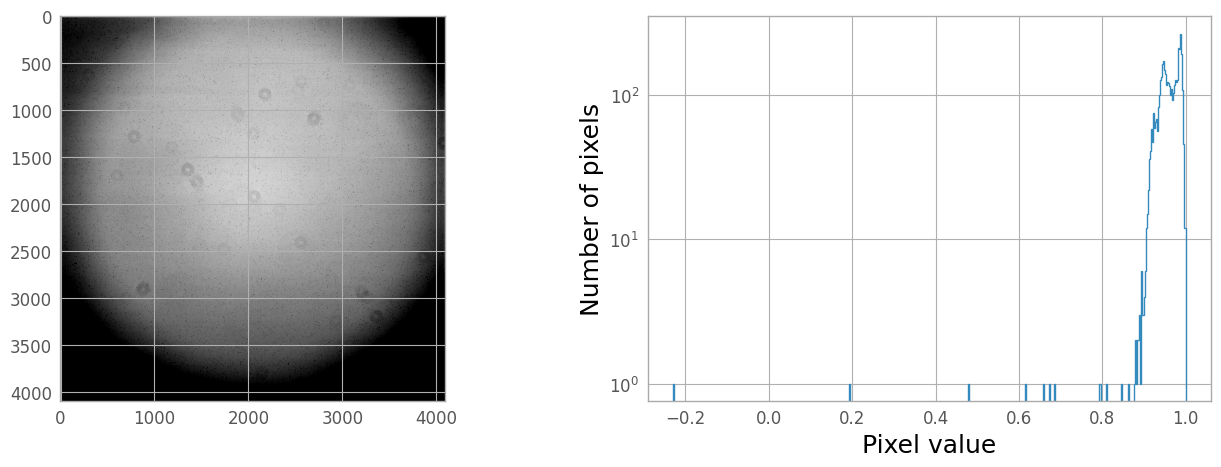

In [35]:
fig=plt.figure(figsize=(16,5))
#Plot image
ax1=fig.add_subplot(121)
ax1.imshow(normgflat, cmap='gray',vmin=np.median(normgflat)*0.95, vmax=np.median(normgflat)*1.05)

pixels=normgflat[0].data

ax2=fig.add_subplot(122)
ax2.hist(pixels.flatten(),histtype='step',bins=500)
ax2.set_yscale('log')
ax2.set_xlabel('Pixel value',fontsize=18)
ax2.set_ylabel('Number of pixels',fontsize=18)

# Measuring Gain

In [36]:
#Import Flat fields in g-band with 1 various exposure lengths. 
#Create the list of input files
indir=file_root+'DomeFlatfields/'  #Replace with the path to your files!
filelist=[]
for file in os.listdir(indir):
    if (file.endswith(".FIT") and file.startswith("flat_g") ): 
        filelist.append(os.path.join(indir, file))
#Run this command to check your list of files makes sense
for x in filelist:
    print(x)  

/homes/astr341/CCD_Data/DomeFlatfields/flat_g_0.3S1.FIT
/homes/astr341/CCD_Data/DomeFlatfields/flat_g_0.3S2.FIT
/homes/astr341/CCD_Data/DomeFlatfields/flat_g_0.5S1.FIT
/homes/astr341/CCD_Data/DomeFlatfields/flat_g_0.5S2.FIT
/homes/astr341/CCD_Data/DomeFlatfields/flat_g_1.5S1.FIT
/homes/astr341/CCD_Data/DomeFlatfields/flat_g_1.5S2.FIT
/homes/astr341/CCD_Data/DomeFlatfields/flat_g_1S3.FIT
/homes/astr341/CCD_Data/DomeFlatfields/flat_g_1S4.FIT
/homes/astr341/CCD_Data/DomeFlatfields/flat_g_2.5S1.FIT
/homes/astr341/CCD_Data/DomeFlatfields/flat_g_2.5S2.FIT
/homes/astr341/CCD_Data/DomeFlatfields/flat_g_2S1.FIT
/homes/astr341/CCD_Data/DomeFlatfields/flat_g_2S2.FIT
/homes/astr341/CCD_Data/DomeFlatfields/flat_g_3S1.FIT
/homes/astr341/CCD_Data/DomeFlatfields/flat_g_3S2.FIT
/homes/astr341/CCD_Data/DomeFlatfields/flat_g_4S1.FIT
/homes/astr341/CCD_Data/DomeFlatfields/flat_g_4S2.FIT
/homes/astr341/CCD_Data/DomeFlatfields/flat_g_5S1.FIT
/homes/astr341/CCD_Data/DomeFlatfields/flat_g_5S2.FIT


In [48]:
#Need to measure average and standard deviation of the difference of two of the same length. 
#T=5s is saturated so don't use. I think T=4s maybe a bit saturated too. 

#Set up for results. Times from the names of the files. Need one per PAIR of flat fields. 
#This is really bad hard coding, you would need to make it be right for your data! 
time=[0.3,0.5,1.5,1.0,2.5,2.0,3.0]
Flux=[0.0,0.0,0.0,0.0,0.0,0.0,0.0]
SD=[0.0,0.0,0.0,0.0,0.0,0.0,0.0]

for i in range(7):
    file=filelist[2*i]
    print('File to open: ',file)
    flat1 = fits.open(file)   #Read in pre-subtraction image
    flat1_img = flat1[0].data.astype(float)
    file=filelist[2*i+1]
    print('File to open: ',file)
    flat2 = fits.open(file)   #Read in pre-subtraction image
    flat2_img = flat2[0].data.astype(float)

    average=(flat1_img+flat2_img)/2.0
#Recall this is still 4096x4096 numbers, so:
    print('Median pixel value of average frame: ', np.median(average))

    diff=1.0000*flat1_img-1.0000*flat2_img
#Recall this is still 4096x4096 numbers, so:
    print('Median pixel value of difference frame (what should this be?): ', np.median(diff))
    print('Standard deviation of pixel values in a difference frame: ', np.std(diff))

    Flux[i]=np.median(average)
    SD[i]=np.std(diff)/np.sqrt(2.0)



File to open:  /homes/astr341/CCD_Data/DomeFlatfields/flat_g_0.3S1.FIT
File to open:  /homes/astr341/CCD_Data/DomeFlatfields/flat_g_0.3S2.FIT
Median pixel value of average frame:  5536.0
Median pixel value of difference frame (what should this be?):  -30.0
Standard deviation of pixel values in a difference frame:  80.98398091014143
File to open:  /homes/astr341/CCD_Data/DomeFlatfields/flat_g_0.5S1.FIT
File to open:  /homes/astr341/CCD_Data/DomeFlatfields/flat_g_0.5S2.FIT
Median pixel value of average frame:  8255.0
Median pixel value of difference frame (what should this be?):  -55.0
Standard deviation of pixel values in a difference frame:  101.2041179586893
File to open:  /homes/astr341/CCD_Data/DomeFlatfields/flat_g_1.5S1.FIT
File to open:  /homes/astr341/CCD_Data/DomeFlatfields/flat_g_1.5S2.FIT
Median pixel value of average frame:  21940.5
Median pixel value of difference frame (what should this be?):  -66.0
Standard deviation of pixel values in a difference frame:  169.26295196818

[0.3, 0.5, 1.5, 1.0, 2.5, 2.0, 3.0] [5536.0, 8255.0, 21940.5, 15188.5, 35424.0, 28728.0, 42195.5] [57.26432206904291, 71.56211809259246, 119.68698114035567, 98.86023149189634, 150.87611056938542, 136.82454513706605, 162.4635019119278]
Fitted line y=ax+b:  [ 0.63778737 10.62571313]
Pixel gain should be the inverse of the slope of this line, or,  1.5679206802446786
Manufactorer reported value is 2.63 electrons/ADU


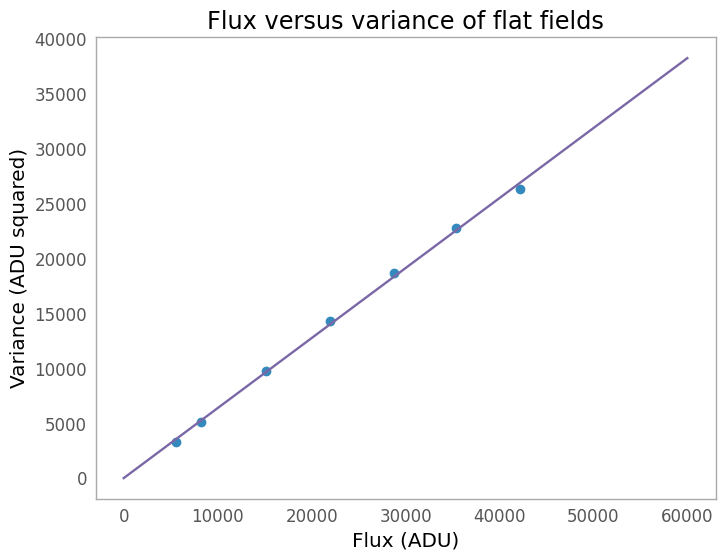

In [49]:
#Debugging line
print(time,Flux,SD)
#Time=Time*60.0
Var=np.square(SD)

fit = np.polyfit(Flux, Var, 1)
print("Fitted line y=ax+b: ", fit)
print('Pixel gain should be the inverse of the slope of this line, or, ', 1/fit[0])
#print("Manufactorer reported value is 2.63 electrons/ADU")
a=fit[0]
b=fit[1]
x=np.linspace(0,60000,1000)
y = a*x+b

#Make a plot
plt.plot(Flux,Var,'o')
plt.plot(x,y)

#Title
plt.title('Flux versus variance of flat fields')

#Axis labels
plt.xlabel("Flux (ADU)")
plt.ylabel("Variance (ADU squared)")

#Add a grid
plt.grid()

#Add a legend box
#plt.legend()

#Actually show the plot
plt.show()

# Basic Aperture Photometry

Here we'll use the bias, dark and flat to do a basic aperture photometry of a single star

In [28]:
#Import Flat fields in g-band with 1 various exposure lengths. 
#Create the list of input files
indir=file_root+'SaturationTestSpica/'  #Replace with path to your data
filelist=[]
for file in os.listdir(indir):
    if (file.endswith(".fit") and file.startswith("spica") ): 
        filelist.append(os.path.join(indir, file))
#Run this command to check your list of files makes sense
for x in filelist:
    print(x)  

CCDCharacterizationBackupData/SaturationTestSpica/spica1.fit
CCDCharacterizationBackupData/SaturationTestSpica/spica2.fit
CCDCharacterizationBackupData/SaturationTestSpica/spica3.fit
CCDCharacterizationBackupData/SaturationTestSpica/spica4.fit
CCDCharacterizationBackupData/SaturationTestSpica/spica5.fit
CCDCharacterizationBackupData/SaturationTestSpica/spica6.fit
CCDCharacterizationBackupData/SaturationTestSpica/spica7.fit
CCDCharacterizationBackupData/SaturationTestSpica/spica8.fit
CCDCharacterizationBackupData/SaturationTestSpica/spica9.fit


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
Exposure time of dark is 1800.0
Exposure time is 0.3
CCD Temp: 13.0


Text(0, 0.5, 'Number of pixels')

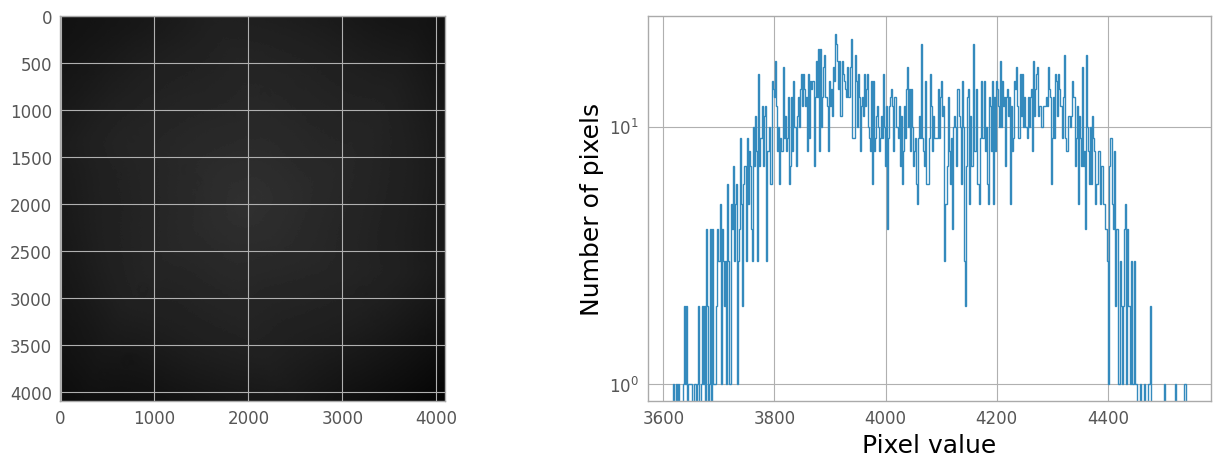

In [43]:
#First we remove the bias and dark current
avbias=CCDData.read(outdir+'averaged_bias.fit', unit="adu")
dark1800=CCDData.read(file_root+'Darks/dark30min_13C.fit', unit="adu")
print('Exposure time of dark is',dark1800.header["EXPTIME"])

spica1 = CCDData.read(filelist[0], unit="adu")  #Read in pre-subtraction image

print('Exposure time is',spica1.header["EXPTIME"])
print("CCD Temp:",spica1.header["CCD-TEMP"])


#Subtract the bias
spica1_bias = ccdp.subtract_bias(spica1, avbias)

data=spica1_bias

#Plot image
fig=plt.figure(figsize=(16,5))
ax1=fig.add_subplot(121)
ax1.imshow(data, cmap='gray')
           #vmin=-1.0*np.median(data)*2.0, vmax=np.median(data)*2.0)

pixels=data[0].data

ax2=fig.add_subplot(122)
ax2.hist(pixels.flatten(),histtype='step',bins=500)
ax2.set_yscale('log')
ax2.set_xlabel('Pixel value',fontsize=18)
ax2.set_ylabel('Number of pixels',fontsize=18)

 id xcenter ycenter aperture_sum
      pix     pix       adu     
--- ------- ------- ------------
  1   265.0   850.0    6724534.3
  2   350.0   840.0   -15316.634


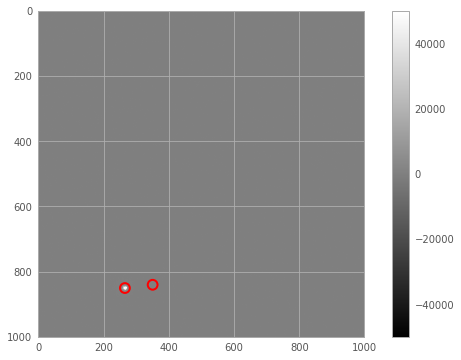

In [99]:
#Subtract the dark from the flat field images 
#(use a dark at a similar temp - which I don't currently have, so not using this).
#Question: what would happen if you use a dark which is at a higher temp?
spica1_reduced = ccdp.subtract_dark(spica1_bias, dark1800,
                              dark_exposure=1800*u.s, 
                              data_exposure=0.05*u.s)

#Pick out roughly the central 1000x1000 pixels
image=spica1_bias[1500:2500,1500:2500]

#Set Aperture
positions = [(265., 850.), (350., 840.)] #positions 30,30 and 40,40
apertures = CircularAperture(positions, r=15.)

phot_table = aperture_photometry(image, apertures)
phot_table['aperture_sum'].info.format = '%.8g'  # for consistent table output
print(phot_table)

#Visualisation data: 
plt.imshow(image, cmap='gray', aspect='equal', interpolation='none')
plt.colorbar() 
plt.clim(-50000,50000)
plt.gcf().set_size_inches(10,6)
apertures.plot(color='red', lw=2)

# Extension Activities #

This is not the only way to do this analysis, and is also based/inspired by parts of the below. 

Documentation for CCDProc: https://ccdproc.readthedocs.io/en/latest/ (which includes some worked examples with other CCD data).

Documentation for Aperture Photometry in Python: https://photutils.readthedocs.io/en/stable/aperture.html

Data Processing with AstroImageJ: http://slittlefair.staff.shef.ac.uk/teaching/phy217/lectures/instruments/L13/index.html (honestly I think for the stellar photometry I would do this instead - please document in your report the method you use). 

Colette Salyk's (Astronomy Professor at Vassar) Pipeline: https://github.com/csalyk/phot_tutorial

Another example of reduction with bias/darks: https://github.com/BrendanReinhart/Huntsman_analysis

